Primero importamos las librerías que vamos a necesitar

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Ahora introducimos la ruta en la que guardamos el archivo con los datos que se analizarán

In [111]:
df = pd.read_csv('/home/luis-loreto/Documentos/Python/Titanic/Tablas/train.csv')

Generamos una previsualización de la información contenida en el .csv

In [6]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Iniciamos con el análisis exploratorio. Vemos cuántos registros tiene cada variable. Se puede observar que son 11 variables independientes y una dependiente: Survived. Ésta última será la variable para el aprendizaje en nuestro modelos de machine learning. 

In [6]:
df.count().reset_index(name="Total")

,index,Total
0,PassengerId,891
1,Survived,891
2,Pclass,891
3,Name,891
4,Sex,891
5,Age,714
6,SibSp,891
7,Parch,891
8,Ticket,891
9,Fare,891


In [16]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Podemos observar que son 891 observaciones en nuestro conjunto de entrenamiento, no obstante, se trata de una base desbalanceada, pues las variables "Age", "cabin" y "Embarked" presentan missings, es decir, registros sin informaición. Si queremos trabajar con alguna de estas tres variables debemos buscar un metodo para reemplazar los registros faltantes, a esto se le conoce como imputación.

Continuando con el análisis exploratorio, podemos empezar a observar cuántos sobrevivientes hubo agrupando por clase.

In [17]:
Pclass = df.groupby(["Survived", "Pclass"])["Survived"].count().reset_index(name="Cantidad")

In [8]:
Pclass

,Survived,Pclass,Cantidad
0,0,1,80
1,0,2,97
2,0,3,372
3,1,1,136
4,1,2,87
5,1,3,119


Ahora bien, podemos hacer una lift table, algo muy común en el análisis de riesgos como una primera métrica descriptiva de cómo se ajusta la variable a nuestra "marca de malo", en este caso Survived

In [13]:
# Pivotear el DataFrame
tabla1 = Pclass.pivot_table(index='Pclass', columns='Survived', values='Cantidad', aggfunc='sum', fill_value=0)
tabla1['Total'] = (tabla1[0] + tabla1[1])
tabla1["% de sobrevivientes"] = (tabla1[1] / tabla1['Total'])
tabla1

Survived,0,1,Total,% de sobrevivientes
Pclass,,,,
1,80,136,216,0.629630
2,97,87,184,0.472826
3,372,119,491,0.242363


Se puede observar que la proporción de sobrevivientes aumenta a medida que la variable Pclase también lo hace. Digamos que esta es una primera aproximación, es una buena manera descriptiva de ver la relación entre una variable binaria y una ordinal categórica. No obstante, son 10 las variables que debemos analizar para saber cuáles de ellas se pueden usar para generar un modelo que prediga la supervivencia

Iniciemos con la exploración de cada variable. A pesar de que la intución nos pueda sugerir que variables como "Name" no deberían ser relevantes para explicar Survived, asumamos que no tenemos nada de teoría, es decir, es un trabajo totalmente empírico y exploratorio. En ciencias sociales, la teoría sirve para tener una dirección y no andar a ciegas en un mar de datos, careciendo de cualquier indicio de casualidad o de explicación. La teoría puede ser algo fantástico (en el buen sentido), pero en nuestro ejercicio prescindiremos totalmente de ella.

In [ ]:
df.groupby('PassengerId').count()

Vamos a contar el número de observaciones según Pclass

In [19]:
df.groupby(["Pclass"])["Pclass"].count().reset_index(name="Cantidad")

,Pclass,Cantidad
0,1,216
1,2,184
2,3,491


In [20]:
#PassengerId
df.groupby(["Sex"])["Sex"].count().reset_index(name="Cantidad")

,Sex,Cantidad
0,female,314
1,male,577


La variable ticket, a primera vista no nos brinda información relevante, pero si observamos más detenidamente, se podrían encontrar varios patrones. Se podrían clasificar de la siguiente manera:
Tickets sin letra
Tickets que inician con alguna letra

Lo más probable es que estos registros tengan errores y se hayan llevado a cabo. Esta variable requiere un trabajo de limpieza y depuración. 
Primero que nada, observamos uqe hay tickets que de 4, 5 o 6 dígitos. No obstante, todos parecen tener continuidad en lo que respecta a los dos primeros dígitos. Por lo tanto, los tíckets sin letra se covertiran en tickets que consistan en los dos primeros dígitos.
Luego están los que inician con letra. Al parecer, los que inician con A, pueden ir seguidos de un 5 o un 4, por lo que estos tickets serán renombrados como A5 o A4 según corresponda. Luego están los que inician con C, CA, FC, 

In [ ]:
Pclass = df.groupby(["Survived", "Pclass"])["Survived"].count().reset_index(name="Cantidad")

In [ ]:
df.groupby(["Survived", "Ticket"])["Survived"].count().reset_index(name="Cantidad")

In [105]:
df['Ticket2'] = df['Ticket'].str[:4]

In [ ]:
df

Ahora vamos a iniciar con la magia de Python. Crearemos una pequeña función que detecte si hay espacios en una variable y que elimine la parte que precede a dicho espacio! 

In [112]:
def primer_caracter_despues_de_eliminar(texto):
    # Eliminar el contenido antes del primer espacio
    parte_despues_espacio = texto.split(' ', 1)[1] if ' ' in texto else texto
    # Retornar el primer carácter de esa parte
    return parte_despues_espacio[0] if parte_despues_espacio else ''


In [114]:
df['primer_caracter'] = df['Ticket'].apply(primer_caracter_despues_de_eliminar)

In [ ]:
df

In [67]:
df['Ticket2'] = df['Ticket'].apply(lambda x: x[4:5] if x.startswith('A/5')
      else (x[4:5] if x.startswith('A.5')  
      else ('A4' if x.startswith('A/4') 
      else ('W' if x.startswith('W.')                         
      else ('CA' if x.startswith('C')  
      else (x[3:4] if x.startswith('PC') 
            else x[:1])
)))))

In [ ]:
df

In [116]:
df.groupby(["primer_caracter"])["primer_caracter"].count().reset_index(name="Cantidad")

,primer_caracter,Cantidad
0,1,231
1,2,242
2,3,355
3,4,15
4,5,8
5,6,14
6,7,15
7,8,3
8,9,3
9,B,1


In [119]:
Ticket = df.groupby(["Survived", "primer_caracter"])["Survived"].count().reset_index(name="Cantidad")

In [120]:
Ticket

,Survived,primer_caracter,Cantidad
0,0,1,91
1,0,2,143
2,0,3,265
3,0,4,13
4,0,5,7
5,0,6,13
6,0,7,11
7,0,8,3
8,0,L,3
9,1,1,140


In [121]:
tabla1 = Ticket.pivot_table(index='primer_caracter', columns='Survived', values='Cantidad', aggfunc='sum', fill_value=0)
tabla1['Total'] = (tabla1[0] + tabla1[1])
tabla1

Survived,0,1,Total
primer_caracter,,,
1,91,140,231
2,143,99,242
3,265,90,355
4,13,2,15
5,7,1,8
6,13,1,14
7,11,4,15
8,3,0,3
9,0,3,3


In [ ]:
tabla1.groupby(["Survived", "primer_caracter"])["Survived"].count().reset_index(name="Cantidad")

In [129]:
tabla1["% de sobrevivientes"] = (tabla1[1] / tabla1['Total'])
tabla1

Survived,0,1,Total,% de sobrevivientes
primer_caracter,,,,
1,91,140,231,0.606061
2,143,99,242,0.409091
3,265,90,355,0.253521
4,13,2,15,0.133333
5,7,1,8,0.125000
6,13,1,14,0.071429
7,11,4,15,0.266667
8,3,0,3,0.000000
9,0,3,3,1.000000


Al parecer, los pasajeros que inician con un 1 en tienen una mayor probabilidad de sobrevivir que los que tienen un 9!

In [21]:
df.groupby(["SibSp"])["SibSp"].count().reset_index(name="Cantidad")

,SibSp,Cantidad
0,0,608
1,1,209
2,2,28
3,3,16
4,4,18
5,5,5
6,8,7


In [22]:
df.groupby(["Parch"])["Parch"].count().reset_index(name="Cantidad")

,Parch,Cantidad
0,0,678
1,1,118
2,2,80
3,3,5
4,4,4
5,5,5
6,6,1


In [ ]:
df.groupby(["Age"])["Age"].count().reset_index(name="Cantidad")

In [103]:
Pclass = df.groupby(["Survived", "Pclass"])["Survived"].count().reset_index(name="Cantidad")

In [58]:
clase = df[["Pclass", "Survived"]]

<AxesSubplot: >

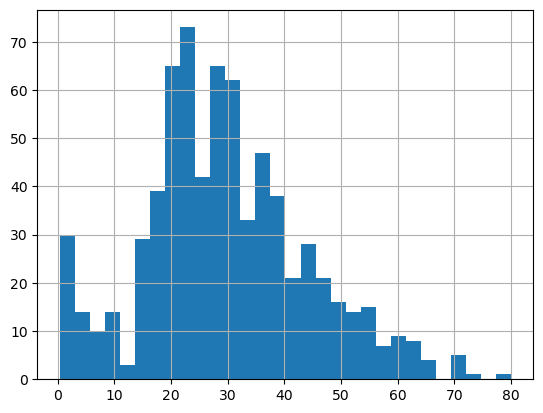

In [61]:
df["Age"].hist(bins = 30)

La variable Age presenta valores faltantes, por lo que es necesario utilizar algún método de imputración para empezar a trabajar con modelos. Debido a que no son muchos los valores faltantes, usaremos el método Hot Deck Imputation.

In [134]:
from imputena import random_hot_deck_imputation

ModuleNotFoundError: No module named 'imputena'

<AxesSubplot: >

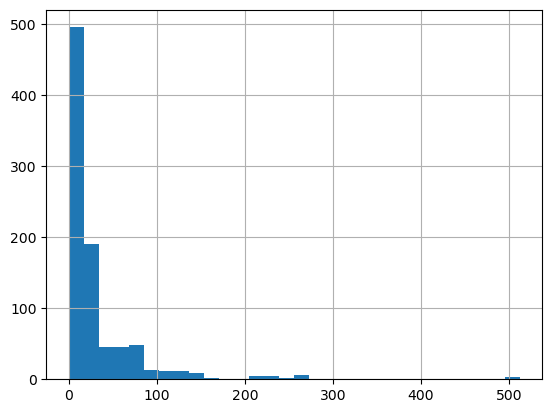

In [62]:
df["Fare"].hist(bins = 30)

In [131]:
df.groupby(["Survived", "Cabin"])["Survived"].count().reset_index(name="Cantidad")

,Survived,Cabin,Cantidad
0,0,A10,1
1,0,A14,1
2,0,A19,1
3,0,A24,1
4,0,A32,1
5,0,A36,1
6,0,A5,1
7,0,A7,1
8,0,B102,1
9,0,B19,1


Es hora de hacer nuestro primer modelito! iniciaremos con una sencilla regresión logístic

In [137]:
import missingno as msno

ModuleNotFoundError: No module named 'missingno'